In [3]:
import copy
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle
from model import get_bellasio2019
from mxlpy import Model, Simulator, cartesian_product, make_protocol, scan

import mxlbricks.names as n


## Figure 3

In [4]:
def create_fig3_sim(
    fig3_m: Model,
    p_O2_list: list[int],
    pfd_list: list[int],
    ca_list: list[int]
):      
    fig3_m.update_parameters({
        "Ca": 400,
        n.pfd(): 1500,
    })

    parameters_pfd = cartesian_product({
        n.pfd(): pfd_list,
        "p_o2": p_O2_list
    })

    parameters_ca = cartesian_product({
        "Ca": ca_list,
        "p_o2": p_O2_list
    })

    fig3_res_pfd = scan.time_course(
        model=fig3_m,
        to_scan=parameters_pfd,
        time_points=np.linspace(0, 1800, 1000)
    )

    fig3_res_pfd = fig3_res_pfd.combined
    fig3_res_pfd = fig3_res_pfd.reset_index().groupby("n").last().drop(columns=["time"])
    fig3_res_pfd = pd.concat([fig3_res_pfd, parameters_pfd], axis=1)
    fig3_res_pfd = fig3_res_pfd.set_index([n.pfd(), "p_o2"])

    fig3_res_ca = scan.time_course(
        model=fig3_m,
        to_scan=parameters_ca,
        time_points=np.linspace(0, 1800, 1000)
    )

    fig3_res_ca = fig3_res_ca.combined
    fig3_res_ca = fig3_res_ca.reset_index().groupby("n").last().drop(columns=["time"])
    fig3_res_ca = pd.concat([fig3_res_ca, parameters_ca], axis=1)
    fig3_res_ca["Ci_init"] = fig3_res_ca["Ca"] * 0.65
    fig3_res_ca = fig3_res_ca.set_index(["Ca", "p_o2"])
    
    return fig3_res_pfd, fig3_res_ca

def create_fig3_plot(
    fig3_res_pfd: pd.DataFrame,
    fig3_res_ca: pd.DataFrame,
    p_O2_list: list[int]
):
    fig3, axs = plt.subplots(nrows=3, ncols=2, figsize=(10,10))

    pO2_styles = {
        "color": {
            "210000": '#ff7f40',
            "20000": '#0020f2'
        },
        "marker": {
            "210000": 'o',
            "20000": 'v'
        }
    }

    for pO2 in p_O2_list:
        res_pfd = fig3_res_pfd.xs(pO2, axis=0, level=1, drop_level=True)
        res_ca = fig3_res_ca.xs(pO2, axis=0, level=1, drop_level=True)
        
        if pO2 == 210000:
            label = "Modelled Ambient $O_2$"
        else:
            label = "Modelled Low $O_2$"
        
        for i, res in enumerate([res_pfd, res_ca]):
            axs[0, i].plot(res["A"] * 1000, color=pO2_styles["color"][str(pO2)], marker=pO2_styles["marker"][str(pO2)], ls="None", markerfacecolor="none", label=label)
            axs[1, i].plot(res["gs"], color=pO2_styles["color"][str(pO2)], marker=pO2_styles["marker"][str(pO2)], ls="None", markerfacecolor="none")
            axs[2, i].plot(res["v_NADPH"] * 1000, color=pO2_styles["color"][str(pO2)], marker=pO2_styles["marker"][str(pO2)], ls="None", markerfacecolor="none")

    # Figure stylings

    # Subplot titles
    for i, ax in enumerate(axs.flat):
        ax.text(-0.14, 0.95, string.ascii_lowercase[i], transform=ax.transAxes, fontsize=12, fontweight="bold", va="center", ha="center")
        
    for i, ax in enumerate(axs[0, :]):
        if i == 0:
            ax.set_title("Response to PPFD", fontsize=14)
        else:
            ax.set_title("Response to $C_a$", fontsize=14)
    
    axs[0, 0].legend(loc="best", fontsize=8, frameon=False)

    #X-Axis
    axs[2, 0].set_xlabel("PPFD / $\\mu mol\\ m^{-2}\\ s^{-1}$")
    axs[2, 1].set_xlabel("Ca / $\\mu mol\\ mol^{-1}$")

    xticks_pfd = np.linspace(100, 1500, 8)
    xticks_ci = np.linspace(100, 1100, 6)
    for i, xticks in enumerate([xticks_pfd, xticks_ci]):
        for ax in axs.flat:
            ax.tick_params(
                axis='both',
                which='both',
                direction='in',
                top=True,
                bottom=True
            )
            

        for ax in axs[:, i]:
            ax.set_xticks(xticks)
        axs[2, i].tick_params(
                axis='both',
                which='both',
                direction='out',
                top=False,
                bottom=True
            )
        sec_ax = axs[2, i].secondary_xaxis('top')
        sec_ax.set_xticks(xticks)
        sec_ax.tick_params(
                axis='both',
                which='both',
                direction='in',
                labeltop=False,
            )

    # Ylabels
    for ax in axs[0, :]:
        ax.set_ylabel("A / $\\mu mol\\ m^{-2}\\ s^{-1}$")
        ax.set_ylim(0, 40)
        ax.set_yticks(np.linspace(5, 35, 4))
        
    for ax in axs[1, :]:
        ax.set_ylabel("gs / $mol\\ m^{-2}\\ s^{-1}$")
        ax.set_ylim(0, 0.50)
        ax.set_yticks(np.linspace(0.05, 0.45, 5))
        
    for ax in axs[2, :]:
        ax.set_ylabel("$v_{NADPH}$ / $\\mu mol\\ m^{-2}\\ s^{-1}$")
        ax.set_ylim(0, 110)
        ax.set_yticks(np.linspace(20, 100, 5))

    plt.subplots_adjust(hspace=0, wspace=0.3)

    return fig3, axs

100%|██████████| 34/34 [00:25<00:00,  1.33it/s]


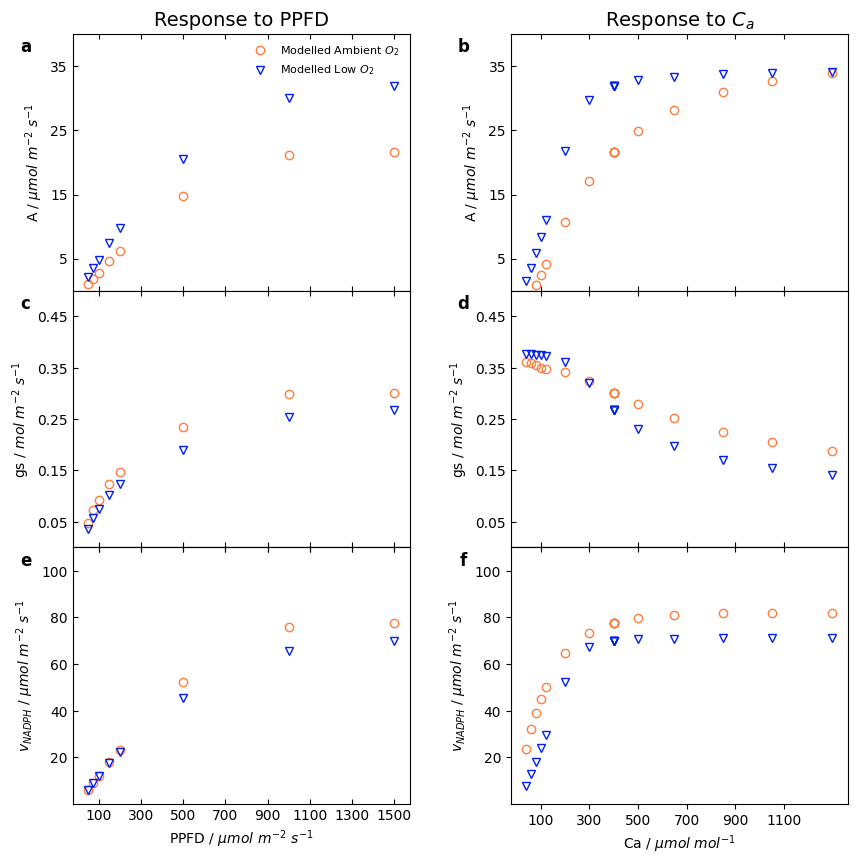

In [5]:
p_O2_list = [21_0000, 2_0000]
pfd_list = [50, 75, 100, 150, 200, 500, 1000, 1500]
ca_list = [400, 300, 200, 120, 100, 80, 60, 40, 400, 400, 400, 400, 500, 650, 850, 1050, 1300]

fig3_res_pfd, fig3_res_ca = create_fig3_sim(
    fig3_m=get_bellasio2019(),
    p_O2_list=p_O2_list,
    pfd_list=pfd_list,
    ca_list=ca_list
)

create_fig3_plot(
    fig3_res_pfd=fig3_res_pfd,
    fig3_res_ca=fig3_res_ca,
    p_O2_list=p_O2_list
)

plt.show()

# Figure 4

In [6]:
def create_fig4_plot(
    model: Model,
    fig4_res_pfd: pd.DataFrame,
    fig4_res_ca: pd.DataFrame,
    p_O2_list: list[int]
):
    fig4, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 11))

    pO2_styles = {
        "color": {
            "210000": '#ff7f40',
            "20000": '#0020f2'
        },
        "marker": {
            "210000": 'o',
            "20000": 'v'
        }
    }

    for pO2 in p_O2_list:
        res_pfd = fig4_res_pfd.xs(pO2, axis=0, level=1, drop_level=True)
        res_ca = fig4_res_ca.xs(pO2, axis=0, level=1, drop_level=True)
        
        if pO2 == 210000:
            label = "Modelled Ambient $O_2$"
        else:
            label = "Modelled Low $O_2$"
        
        for i, res in enumerate([res_pfd, res_ca]):
            axs[0, i].plot(res[n.rubp()] * model.get_parameter_values()["V_m"] * 1000, color=pO2_styles["color"][str(pO2)], marker=pO2_styles["marker"][str(pO2)], ls="None", markerfacecolor="none", label=label)
            axs[1, i].plot(res[n.pga()] * model.get_parameter_values()["V_m"] * 1000, color=pO2_styles["color"][str(pO2)], marker=pO2_styles["marker"][str(pO2)], ls="None", markerfacecolor="none")
            axs[2, i].plot(res["Ract"] * res["f_rubp"], color=pO2_styles["color"][str(pO2)], marker=pO2_styles["marker"][str(pO2)], ls="None", markerfacecolor="none")

    # Figure stylings

    # Subplot titles
    for i, ax in enumerate(axs.flat):
        ax.text(-0.14, 0.95, string.ascii_lowercase[i], transform=ax.transAxes, fontsize=12, fontweight='bold', va='center', ha='center')
        
    for i, ax in enumerate(axs[0, :]):
        if i == 0:
            ax.set_title("Response to PPFD", fontsize=14)
        else:
            ax.set_title("Response to $C_a$", fontsize=14)
            
    axs[0, 0].legend(loc="best", fontsize=8, frameon=False)

    #X-Axis
    axs[2, 0].set_xlabel("PPFD / $\\mu mol\\ m^{-2}\\ s^{-1}$")
    axs[2, 1].set_xlabel("Ca / $\\mu mol\\ mol^{-1}$")

    xticks_pfd = np.linspace(100, 1500, 8)
    xticks_ci = np.linspace(100, 1100, 6)
    for i, xticks in enumerate([xticks_pfd, xticks_ci]):
        for ax in axs.flat:
            ax.tick_params(
                axis='both',
                which='both',
                direction='in',
                top=True,
                bottom=True
            )
            

        for ax in axs[:, i]:
            ax.set_xticks(xticks)
        axs[2, i].tick_params(
                axis='both',
                which='both',
                direction='out',
                top=False,
                bottom=True
            )
        sec_ax = axs[2, i].secondary_xaxis('top')
        sec_ax.set_xticks(xticks)
        sec_ax.tick_params(
                axis='both',
                which='both',
                direction='in',
                labeltop=False,
            )

    # Y-Axis
    for ax in axs[0, :]:
        ax.set_ylabel("RuBP / $\\mu mol\\ m^{-2}$")
        ax.set_ylim(0, 250)
        ax.set_yticks(np.linspace(50, 200, 4))
        
    for ax in axs[1, :]:
        ax.set_ylabel("PGA / $\\mu mol\\ m^{-2}$")
        ax.set_ylim(0, 325)
        ax.set_yticks(np.linspace(100, 300, 3))
        
    for ax in axs[2, :]:
        ax.set_ylabel("Rubisco Rel. Activity")
        ax.set_ylim(0, 1.1)
        ax.set_yticks(np.linspace(0.2, 1.0, 5))

    plt.subplots_adjust(hspace=0)

    return fig4, axs

100%|██████████| 34/34 [00:25<00:00,  1.32it/s]


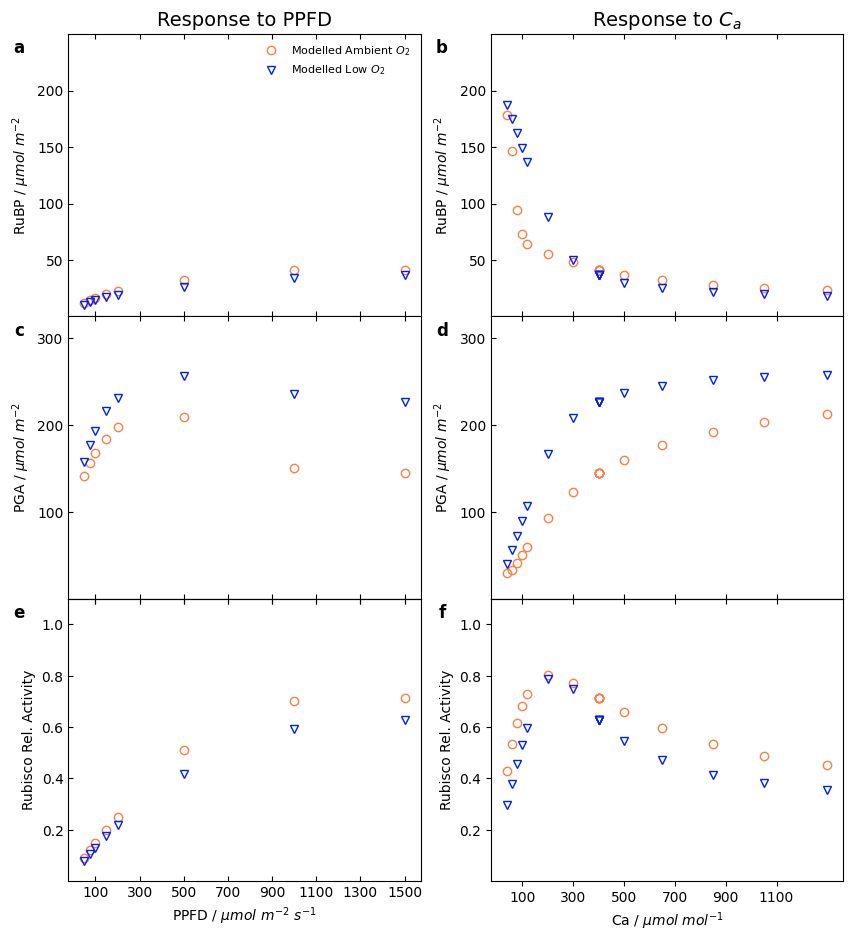

In [7]:
p_O2_list = [21_0000, 2_0000]
pfd_list = [50, 75, 100, 150, 200, 500, 1000, 1500]
ca_list = [400, 300, 200, 120, 100, 80, 60, 40, 400, 400, 400, 400, 500, 650, 850, 1050, 1300]

m = get_bellasio2019()

fig3_res_pfd, fig3_res_ca = create_fig3_sim(
    fig3_m=m,
    p_O2_list=p_O2_list,
    pfd_list=pfd_list,
    ca_list=ca_list
)

create_fig4_plot(
    model=m,
    fig4_res_pfd=fig3_res_pfd,
    fig4_res_ca=fig3_res_ca,
    p_O2_list=p_O2_list
)

plt.show()

# Figure 5

In [60]:
def create_fig5_sim(
    model: Model
):
    model.update_parameters({
        "Ca": 350,
        n.vmax(n.rubisco_carboxylase()): 0.18,
        "chi_beta": 0.8,
        "tau0": -0.12,
        "Ki": 3600,
        "Kd": 1200,
    })
    
    acc_duration = 400
    
    res_complete = {}
    
    for acc_pfd, sim_pfd in [(50, 1500), (1500, 50)]:
        s = Simulator(
            model,
            simulation_parameters = {"atol": 1e-12}
        )
        s.update_parameter(n.pfd(), acc_pfd)
        s.simulate_to_steady_state()

        new_y0 = s.get_result().unwrap_or_err().get_new_y0()
        model_copy = copy.deepcopy(model)
        model_copy.update_variables(new_y0)
        s = Simulator(model_copy)
        
        s.simulate_protocol(
            protocol=make_protocol([
                (acc_duration, {n.pfd(): acc_pfd}),
                (1800, {n.pfd(): sim_pfd})
            ]),
            time_points_per_step=1000
        )
        
        res = s.get_result().unwrap_or_err().get_combined()
        res.index = res.index - acc_duration
        # res = res.loc[res.index >= 0]
        
        res_complete[str(sim_pfd)] = res
    
    return res_complete

def create_fig5_plot(
    model: Model,
    fig5_res: dict[str, pd.DataFrame]
):
    fig5, axs = plt.subplots(nrows=4, ncols=2, figsize=(10, 11))
    
    orange = "#fb8234"
    green = "#19bc72"
    blue = "#6fe3e2"
    red = "#dc2b25"
    pink = "#e293bf"
    
    style_dict = {
        "A": {"color": orange, "linestyle": "solid", "lw": 1},
        "v_ATP": {"color": green, "linestyle": "solid", "lw": 2},
        "v_NADPH": {"color": blue, "linestyle": "dashdot", "lw": 1},
        "gs": {"color": orange, "ls": "solid", "lw": 1},
        "Ract": {"color": green, "ls": "dashdot", "lw": 1},
        "f(rubp)": {"color": blue, "ls": "dashed", "lw": 1},
        "Pi": {"color": red, "ls": "dashed", "lw": 1},
        "RuBP": {"color": pink, "ls": "dashdot", "lw": 1},
        "PGA": {"color": green, "ls": "solid", "lw": 2},
        "DHAP": {"color": blue, "ls": "solid", "lw": 1},
        "ATP/Atot": {"color": red, "ls": "solid", "lw": 1},
        "NADPH/Ntot": {"color": blue, "ls": "dashed", "lw": 1}
    }

    for i, (sim_pfd, df) in enumerate(fig5_res.items()):
        # Row 0: A, v_ATP / 3, v_NADPH / 2
        axs[0, i].plot(df["A"] * 1000, **style_dict["A"], label="Modelled A")
        axs[0, i].plot(df["v_ATP"] / 3 * 1000, **style_dict["v_ATP"], label="$v_{ATP} / 3$")
        axs[0, i].plot(df["v_NADPH"] / 2 * 1000, **style_dict["v_NADPH"], label="$v_{NADPH} / 2$")
        # Row 1: gs, Ract, f(rubp)
        axs[1, i].plot(df["gs"], **style_dict["gs"], label="Modelled $g_s$")
        axs[1, i].plot(df["Ract"], **style_dict["Ract"], label="Rub. Act. St.")
        axs[1, i].plot(df["f_rubp"], **style_dict["f(rubp)"], label="f(RuBP)")
        # Row 2: Pi, RuBP, PGA, DHAP
        axs[2, i].plot(df[n.pi()], **style_dict["Pi"], label="Pi")
        axs[2, i].plot(df[n.rubp()], **style_dict["RuBP"], label="RuBP")
        axs[2, i].plot(df[n.pga()], **style_dict["PGA"], label="PGA")
        axs[2, i].plot(df[n.dhap()], **style_dict["DHAP"], label="DHAP")
        # Row 3: ATP / Atot, NADPH / Ntot
        axs[3, i].plot(df[n.atp()] / model.get_parameter_values()[n.total_adenosines()], **style_dict["ATP/Atot"], label="[ATP] / Atot")
        axs[3, i].plot(df[n.nadph()] / model.get_parameter_values()[n.total_nadp()], **style_dict["NADPH/Ntot"], label="[NADPH] / Ntot")
        

    # Figure stylings

    # Subplot titles
    for i, ax in enumerate(axs.flat):
        ax.text(-0.14, 0.95, string.ascii_lowercase[i], transform=ax.transAxes, fontsize=12, fontweight='bold', va='center', ha='center')
        ax.legend(loc="best", fontsize=8, frameon=False)

    #X-Axis
    for ax in axs[-1, :]:
        ax.set_xlabel("time / s")
    
    xticks_left = np.linspace(0, 1400, 8)
    xticks_right = np.linspace(0, 1000, 6)
    for i, xticks in enumerate([xticks_left, xticks_right]):
        for ax in axs.flat:
            ax.tick_params(
                axis='both',
                which='both',
                direction='in',
                top=True,
                bottom=True
            )
            

        for ax in axs[:, i]:
            ax.set_xticks(xticks)
            if i==0:
                ax.set_xlim(-100, 1600)
            else:
                ax.set_xlim(-100, 1100)
        axs[-1, i].tick_params(
                axis='both',
                which='both',
                direction='out',
                top=False,
                bottom=True
            )
        sec_ax = axs[-1, i].secondary_xaxis('top')
        sec_ax.set_xticks(xticks)
        sec_ax.tick_params(
                axis='both',
                which='both',
                direction='in',
                labeltop=False,
            )

    # Y-Axis
    for i, ax in enumerate(axs[0, :]):
        ax.set_ylabel("Flux / $\\mu mol\\ m^{-2}\\ s^{-1}$")
        if i==0:
            ax.set_ylim(0, 55)
            ax.set_yticks(np.linspace(10, 50, 5))
            ax.set_title("50 to 1500 $\\mu mol\\ m^{-2}\\ s^{-1}$ PPFD")
        else:
            ax.set_ylim(-2, 8)
            ax.set_yticks(np.linspace(2, 8, 4))
            ax.set_title("1500 to 50 $\\mu mol\\ m^{-2}\\ s^{-1}$ PPFD")
        
    for i, ax in enumerate(axs[1, :]):
        ax.set_ylabel("$g_s$, $R_{act}$, $f$(RUBP)")
        if i==0:
            ax.set_ylim(0.1, 1.0)
            
        else:
            ax.set_ylim(0, 1.0)
        ax.set_yticks(np.linspace(0.2, 1.0, 5))
        
    for i, ax in enumerate(axs[2, :]):
        ax.set_ylabel("Concentration / mM")
        if i==0:
            ax.set_ylim(0, 9)
            ax.set_yticks(np.linspace(2, 8, 4))
        else:
            ax.set_ylim(-1, 10)
            ax.set_yticks(np.linspace(2, 8, 4))
    
    for i, ax in enumerate(axs[3, :]):
        ax.set_ylabel("Ratio")
        if i==0:
            ax.set_ylim(0, 1)
            ax.set_yticks(np.linspace(0.2, 0.8, 4))
        else:
            ax.set_ylim(-0.1, 1)
            ax.set_yticks(np.linspace(0.2, 0.8, 4))

    plt.subplots_adjust(hspace=0)

    return fig5, axs

In [61]:
m = get_bellasio2019()

fig5_res = create_fig5_sim(
    model=m
)

create_fig5_plot(
    model=m,
    fig5_res=fig5_res
)

plt.show()

TypeError: Simulator.__init__() got an unexpected keyword argument 'simulation_parameters'

# Figure 6

In [ ]:
def create_fig6_sim(
    model: Model
):
    model.update_parameters({
        n.pfd(): 1500,
        n.vmax(n.rubisco_carboxylase()): 0.18,
        "chi_beta": 0.8,
        "tau0": -0.12,
        "Ki": 3600,
        "Kd": 1200,
    })
    
    acc_duration = 400
    
    res_complete = {}
    
    for acc_ca, sim_ca in [(350, 1500), (1500, 350)]:
        s = Simulator(model)
        s.update_parameter("Ca", acc_ca)
        s.simulate_to_steady_state()

        new_y0 = s.get_result().get_new_y0()
        model_copy = copy.deepcopy(model)
        model_copy.update_variables(new_y0)
        s = Simulator(model_copy)
        
        s.simulate_protocol(
            protocol=make_protocol([
                (acc_duration, {"Ca": acc_ca}),
                (500, {"Ca": sim_ca})
            ]),
            time_points_per_step=1000
        )
        
        res = s.get_result().get_combined()
        res.index = res.index - acc_duration
        
        res_complete[str(sim_ca)] = res
    
    return res_complete

def create_fig6_plot(
    model: Model,
    fig6_res: dict[str, pd.DataFrame]
):
    fig6, axs = plt.subplots(nrows=4, ncols=2, figsize=(10, 11))
    
    orange = "#fb8234"
    green = "#19bc72"
    blue = "#6fe3e2"
    red = "#dc2b25"
    pink = "#e293bf"
    
    style_dict = {
        "A": {"color": orange, "linestyle": "solid", "lw": 1},
        "v_ATP": {"color": green, "linestyle": "solid", "lw": 2},
        "v_NADPH": {"color": blue, "linestyle": "dashdot", "lw": 1},
        "gs": {"color": orange, "ls": "solid", "lw": 1},
        "Ract": {"color": green, "ls": "dashdot", "lw": 1},
        "f(rubp)": {"color": blue, "ls": "dashed", "lw": 1},
        "Pi": {"color": red, "ls": "dashed", "lw": 1},
        "RuBP": {"color": pink, "ls": "dashdot", "lw": 1},
        "PGA": {"color": green, "ls": "solid", "lw": 2},
        "DHAP": {"color": blue, "ls": "solid", "lw": 1},
        "ATP/Atot": {"color": red, "ls": "solid", "lw": 1},
        "NADPH/Ntot": {"color": blue, "ls": "dashed", "lw": 1}
    }

    for i, (sim_ca, df) in enumerate(fig6_res.items()):
        # Row 0: A, v_ATP / 3, v_NADPH / 2
        axs[0, i].plot(df["A"] * 1000, **style_dict["A"], label="Modelled A")
        axs[0, i].plot(df["v_ATP"] / 3 * 1000, **style_dict["v_ATP"], label="$v_{ATP} / 3$")
        axs[0, i].plot(df["v_NADPH"] / 2 * 1000, **style_dict["v_NADPH"], label="$v_{NADPH} / 2$")
        # Row 1: gs, Ract, f(rubp)
        axs[1, i].plot(df["gs"], **style_dict["gs"], label="Modelled $g_s$")
        axs[1, i].plot(df["f_rubp"], **style_dict["f(rubp)"], label="f(RuBP)")
        axs[1, i].plot(df["Ract"], **style_dict["Ract"], label="Rub. Act. St.")
        # Row 2: Pi, RuBP, PGA, DHAP
        axs[2, i].plot(df[n.pi()], **style_dict["Pi"], label="Pi")
        axs[2, i].plot(df[n.rubp()], **style_dict["RuBP"], label="RuBP")
        axs[2, i].plot(df[n.pga()], **style_dict["PGA"], label="PGA")
        axs[2, i].plot(df[n.dhap()], **style_dict["DHAP"], label="DHAP")
        # Row 3: ATP / Atot, NADPH / Ntot
        axs[3, i].plot(df[n.atp()] / model.get_parameter_values()[n.total_adenosines()], **style_dict["ATP/Atot"], label="[ATP] / Atot")
        axs[3, i].plot(df[n.nadph()] / model.get_parameter_values()[n.total_nadp()], **style_dict["NADPH/Ntot"], label="[NADPH] / Ntot")
        

    # Figure stylings

    # Subplot titles
    for i, ax in enumerate(axs.flat):
        ax.text(-0.14, 0.95, string.ascii_lowercase[i], transform=ax.transAxes, fontsize=12, fontweight='bold', va='center', ha='center')
        ax.legend(loc="best", fontsize=8, frameon=False)

    #X-Axis
    for ax in axs[-1, :]:
        ax.set_xlabel("time / s")
    
    xticks_left = np.linspace(0, 250, 6)
    xticks_right = np.linspace(0, 200, 5)
    for i, xticks in enumerate([xticks_left, xticks_right]):
        for ax in axs.flat:
            ax.tick_params(
                axis="both",
                which="both",
                direction="in",
                top=True,
                bottom=True
            )
            

        for ax in axs[:, i]:
            ax.set_xticks(xticks)
            if i==0:
                ax.set_xlim(-100, 300)
            else:
                ax.set_xlim(-100, 250)
        axs[-1, i].tick_params(
                axis="both",
                which="both",
                direction="out",
                top=False,
                bottom=True
            )
        sec_ax = axs[-1, i].secondary_xaxis("top")
        sec_ax.set_xticks(xticks)
        sec_ax.tick_params(
                axis="both",
                which="both",
                direction="in",
                labeltop=False,
            )

    # Y-Axis
    for i, ax in enumerate(axs[0, :]):
        if i==0:
            ax.set_title("350 to 1500 $\\mu mol\\ mol^{-1}$ Ca")
        else:
            ax.set_title("1500 to 350 $\\mu mol\\ mol^{-1}$ Ca")
        ax.set_ylabel("Flux / $\\mu mol\\ m^{-2}\\ s^{-1}$")
        ax.set_ylim(0, 50)
        ax.set_yticks(np.linspace(10, 50, 5))
        
    for i, ax in enumerate(axs[1, :]):
        ax.set_ylabel("$g_s$, $R_{act}$, $f$(RUBP)")
        if i==0:
            ax.set_ylim(0.1, 1.0)
            
        else:
            ax.set_ylim(0, 1.0)
        ax.set_yticks(np.linspace(0.2, 1.0, 5))
        
    for ax in axs[2, :]:
        ax.set_ylabel("Concentration / mM")
        ax.set_ylim(0, 10)
        ax.set_yticks(np.linspace(2, 8, 4))
    
    for ax in axs[3, :]:
        ax.set_ylabel("Ratio")
        ax.set_ylim(0, 1)
        ax.set_yticks(np.linspace(0.2, 0.8, 4))

    plt.subplots_adjust(hspace=0)

    return fig6, axs

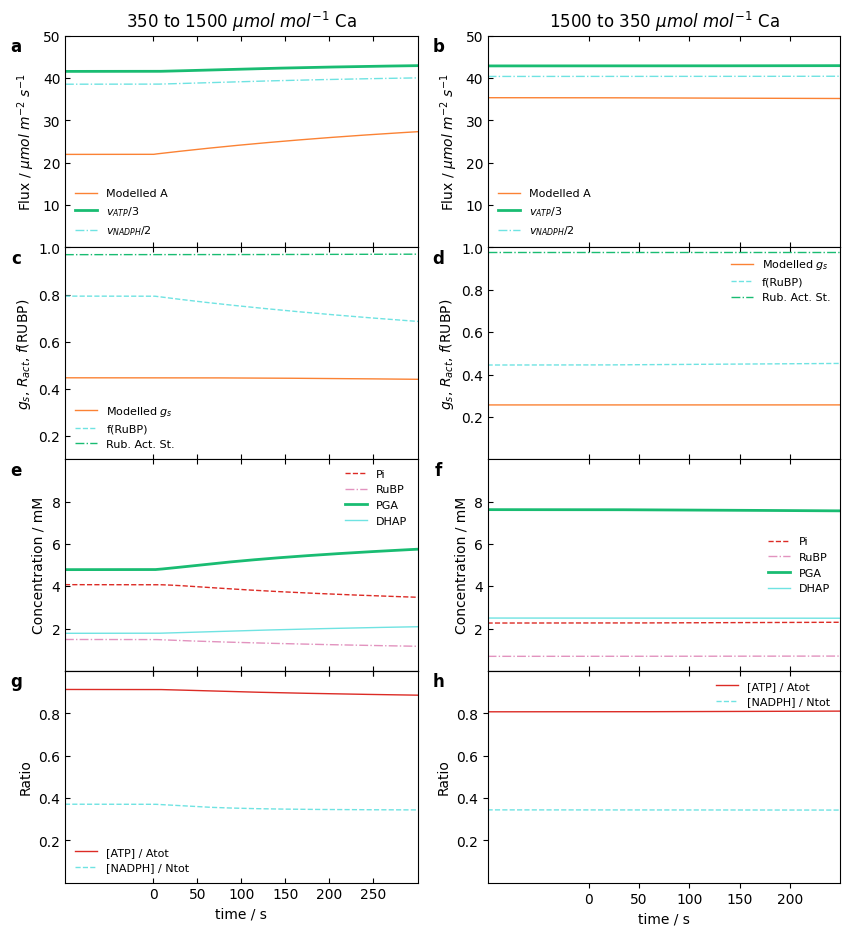

In [ ]:
m = get_bellasio2019()

fig6_res = create_fig6_sim(
    model=m
)

create_fig6_plot(
    model=m,
    fig6_res=fig6_res
)

plt.show()

# Figure 7

In [ ]:
def create_fig7_sim(
    model: Model,
):
    model.update_parameters({
        n.pfd(): 300,
        "Ca": 200,
        "p_o2": 210000
    })
    
    s = Simulator(model)
    
    s.simulate_to_steady_state()
    new_y0 = s.get_result().get_new_y0()
    
    model_copy = copy.deepcopy(model)
    model_copy.update_variables(new_y0)
    s = Simulator(model_copy)

    
    s.simulate_protocol(
        protocol=make_protocol([
            (250, {"p_o2": 210000}),
            (700, {"p_o2": 20000}),
        ]),
        time_points_per_step=1000
    )
    
    res = s.get_result().get_combined()
    res = res.loc[res.index >= 50]
    
    return res

def create_fig7_plot(
    fig7_res: pd.DataFrame
):
    fig7, ax = plt.subplots(figsize=(6, 4))
    
    l1 = ax.plot(fig7_res["A"] * 1000, color="#00c96d", label="Modelled A")
    ax.set_ylabel("Net Assimilation / $\\mu mol\\ m^{-2}\\ s^{-1}$")
    ax.set_xlabel("Time / s")
    ax.set_ylim(5, 20)
    ax.set_yticks(np.linspace(6, 18, 5))
    ax.set_xlim(0, 700)
    ax.set_xticks(np.linspace(100, 600, 6))
    
    ax2 = ax.twinx()
    ax2.set_ylabel("Y(II)")
    l2 = ax2.plot(fig7_res["Y(II)"], color="#868686", ls="dotted", lw=2, label="Modelled Y(II)")
    ax2.set_ylim(0, 0.8)
    ax2.set_yticks(np.linspace(0.1, 0.7, 4))
    
    ax.legend(l1 + l2, [l.get_label() for l in l1 + l2], loc="lower right", frameon=False)
    
    patch_height = 1
    
    p1 = ax.add_patch(
        Rectangle(
            xy=(0, ax.get_ylim()[1] - patch_height),
            width=250,
            height=patch_height,
            facecolor="#fd8040",
        )
    )
    
    p2 = ax.add_patch(
        Rectangle(
            xy=(250, ax.get_ylim()[1] - patch_height),
            width=ax.get_xlim()[1] - 250,
            height=patch_height,
            facecolor="#0000fe",
        )
    )
    
    for p in [p1, p2]:
        if p.get_x() == 0:
            ax.text(
                p.get_x() + p.get_width() / 2,
                p.get_y() + patch_height / 2,
                "Ambient O$_2$",
                color="white",
                fontsize=10,
                ha="center",
                va="center"
            )
        else:
            ax.text(
                p.get_x() + p.get_width() / 2,
                p.get_y() + patch_height / 2,
                "2% O$_2$",
                color="white",
                fontsize=10,
                ha="center",
                va="center"
            )
    
    return fig7, ax

(<Figure size 600x400 with 2 Axes>,
 <Axes: xlabel='Time / s', ylabel='Net Assimilation / $\\mu mol\\ m^{-2}\\ s^{-1}$'>)

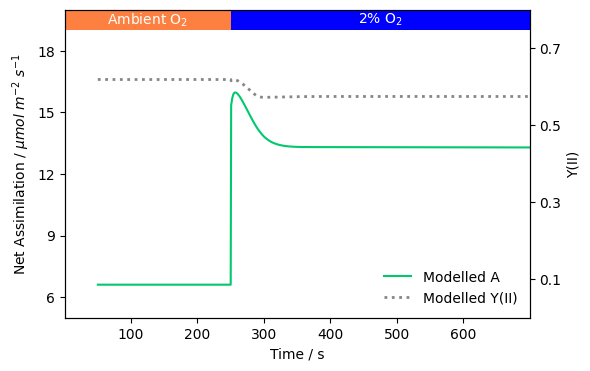

In [ ]:
fig7_res = create_fig7_sim(
    model=get_bellasio2019(),
)

create_fig7_plot(
    fig7_res=fig7_res
)